In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import tensorflow_text
import pandas as pd
import numpy as np
import tensorflow_addons as tfa

## Preprocessing

In [ ]:
# Import english sentiment
tweets = pd.read_pickle("../../Data/english_sentiment_with_confidence.pkl")
tweets.columns = ["text_clean", "iaa"] ## For simplicity rename confidence to iaa
tweets = tweets.sample(2918) ## Take sample

29206

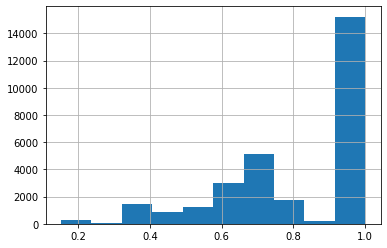

In [ ]:
tweets['iaa'].hist()

In [ ]:
tweets['difficult'] = tweets['iaa'] < 0.9

#### See distribution of difficult and easy to annotate tweets

In [ ]:
difficult = tweets['difficult'].sum()
easy = len(tweets['difficult']) - difficult
print(f"There are {difficult} difficult to annotate tweets and {easy} easy to annotate in the dataset")

There are 13963 difficult to annotate tweets and 15243 easy to annotate in the dataset


### Calculate weights and initial bias

In [ ]:
total = len(tweets)
pos = tweets['difficult'].sum()
neg = total - pos

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
initial_bias = np.log([pos/neg])

### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets[['text_clean',"iaa"]], tweets['difficult'].to_numpy(), 
                                                    test_size=0.2, random_state=42, stratify = tweets['difficult'].to_numpy())

### Neural Network model

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3', 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=False), 
    tf.keras.layers.Dense(512, activation='relu',),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', name="last_output")
])

### Summary of NN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               85213184  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

#### Compile model

In [ ]:
metrics = ['accuracy',
          tf.keras.metrics.Recall(name='recall'),
          tfa.metrics.FBetaScore(name='fbeta', beta=2.,num_classes=1, threshold=0.5)
          ]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=metrics)

Create save best checkpoint - follows validation fbeta score

In [ ]:
checkpoint_filepath = './model_checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_fbeta',
    mode='max',
    save_best_only=True)

In [ ]:
model.fit(X_train["text_clean"].to_numpy(), y_train, epochs=50, batch_size=25, validation_split=0.15, class_weight=class_weight, callbacks=[model_checkpoint_callback])

In [ ]:
model.load_weights("./model_checkpoint/checkpoint")

### Evaluate model

In [ ]:
test_loss = model.evaluate(X_test["text_clean"].to_numpy(), y_test)

In [ ]:
predicted = model.predict(X_test["text_clean"].to_numpy())

In [ ]:
pred = [elem[0] > 0.5  for elem in predicted]

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
cf = confusion_matrix(y_test, pred)
fig, ax = plot_confusion_matrix(conf_mat=cf, colorbar=True)
plt.show()

#### Export results

In [ ]:
#df = pd.DataFrame({"iaa":X_test["iaa"],"Truth":y_test, "Pred":pred, "Prob":[prob[0] for prob in predicted]})

In [ ]:
#df.to_csv("../../Data/resultsNNEnglishSample.csv", index=False)